In [20]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from torchvision import datasets ,models,transforms
import os
import matplotlib.image as img

from torch.utils.data import Dataset, DataLoader
#from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module


In [21]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
device='cpu'

# load data

In [22]:
def readpic(p):
    #return mpimg.imread(p)
    return cv2.imread(p)

def showpic(pic):
    plt.imshow(pic)
    plt.show()

def more_showpic(pic_list):
    fig,ax = plt.subplots(1,5,figsize = (15,3))
    for idx, vactor in enumerate(pic_list[:5]):
        #ax[idx].imshow(vactor)
        ax[idx].imshow(cv2.cvtColor(vactor, cv2.COLOR_BGR2RGB))

In [23]:
#讀取train、validation、test
f = open("./train.txt")
train_txt = f.readlines()
f.close()
f = open("./val.txt")
val_txt = f.readlines()
f.close()
f = open("./test.txt")
test_txt = f.readlines()
f.close()

In [24]:
#train image
train_img_path = []
train_img_label = []
for img_path in train_txt:
    train_path , train_label = img_path.split( )
    train_img_path.append(train_path)
    train_img_label.append(train_label)
#validation image   
val_img_path = []
val_img_label = []
for img_path in val_txt:
    val_path , val_label = img_path.split( )
    val_img_path.append(val_path)
    val_img_label.append(val_label)
#test image     
test_img_path = []
test_img_label = []
for img_path in test_txt:
    test_path , test_label = img_path.split( )
    test_img_path.append(test_path)
    test_img_label.append(test_label)

In [25]:
len(train_img_path),len(val_img_path),len(test_img_path)

(63325, 450, 450)

In [26]:
train = []
val = []
test = []
i = 0
for train_path in train_img_path:
    train.append(readpic(train_path))
        
for val_path, test_path in zip(val_img_path, test_img_path):
    val.append(readpic(val_path))
    test.append(readpic(test_path))

# plot image

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:>]


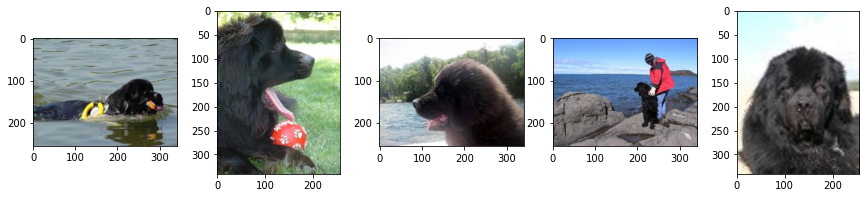

In [27]:
#圖片展示
#opencv读取到的图片是BGR格式的，Matplotlib按照RGB格式解析的
fig,ax = plt.subplots(1,5,figsize = (15,3))
print(ax)
for idx, vactor in enumerate(train[:5]):
    ax[idx].imshow(cv2.cvtColor(vactor, cv2.COLOR_BGR2RGB))

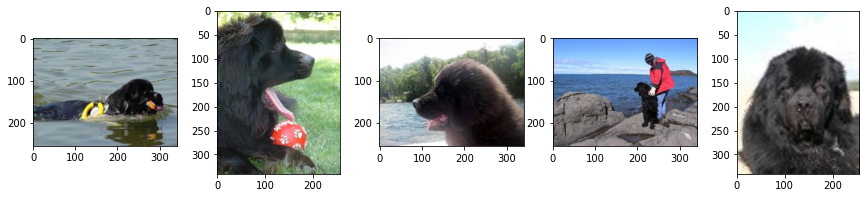

In [28]:
more_showpic(train)

# picture feature

In [29]:
# resize to (256*256)
pic = train[0]
resized = cv2.resize(pic, (256, 256), interpolation=cv2.INTER_AREA)
resized.shape

(256, 256, 3)

### RGB

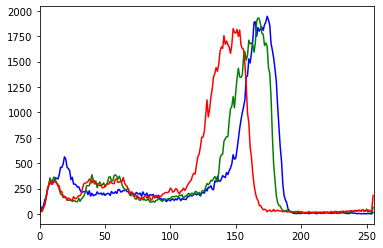

In [30]:
#畫一張圖的RBG分布圖示例
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([pic],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

((63325, 768), numpy.ndarray)

### gray

(256, 343)

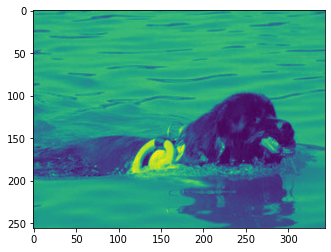

In [14]:
#灰階
#法一
#轉圖片為灰階
gray_try = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_try)
#法二
#直接讀成灰階圖
img_gray = cv2.imread(train_img_path[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray)
img_gray.shape

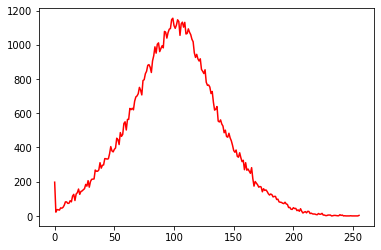

In [104]:
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
# 計算直方圖每個 bin 的數值
hist = cv2.calcHist([pic[:,:,0]], [0], None, [256], [0, 256])
# 畫出直方圖
hist,bins = np.histogram(pic[:,:,0].ravel(), 256, [0,256])
plt.plot(hist, color = col)
#plt.imshow(gray)


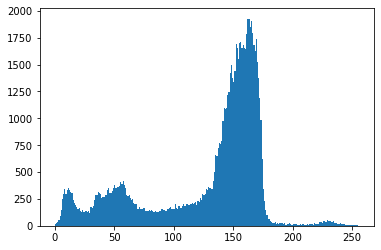

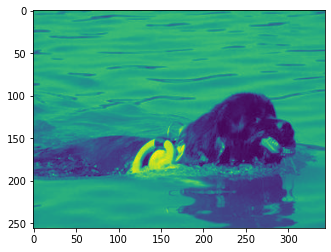

In [15]:
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
'''
    1Darray: 一维数组　这里通过gray.ravel()，把灰度图变为一维数组．
    bins: 统计分隔区间　如果是256 就是分成256份统计, 你可以修改这个值, 看不同的统计效果
    range: 统计数值的空间
'''
plt.hist(gray.ravel(), bins=256, range=[0, 256])
plt.show()
plt.imshow(gray)

# Prepare ML Data

In [46]:
#取所有圖的rbg gray數量
color = ('b','g','r')
red_train = []
blue_train = []
green_train = []
gray_train = []
for pic in train:
    histr_blue = cv2.calcHist([pic],[0],None,[256],[0,256])
    histr_green = cv2.calcHist([pic],[1],None,[256],[0,256])
    histr_red = cv2.calcHist([pic],[2],None,[256],[0,256])
    gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    gray,_ = np.histogram(gray.ravel(), 256, [0,256])
    blue_train.append(histr_blue)
    green_train.append(histr_green)
    red_train.append(histr_red)
    gray_train.append(gray)



In [47]:
blue_train = np.array(blue_train)
green_train = np.array(green_train)
red_train = np.array(red_train)
gray_train = np.array(gray_train)
train_data = np.concatenate((red_train.squeeze(2), green_train.squeeze(2), blue_train.squeeze(2), gray_train), axis=1)

In [230]:
train_data = np.concatenate((red_train.squeeze(2), green_train.squeeze(2), blue_train.squeeze(2), gray_train), axis=1)


In [48]:
#取所有圖的rbg gray數量
color = ('b','g','r')
red_valid = []
blue_valid = []
green_valid = []
gray_valid = []
for pic in val:
    histr_blue = cv2.calcHist([pic],[0],None,[256],[0,256])
    histr_green = cv2.calcHist([pic],[1],None,[256],[0,256])
    histr_red = cv2.calcHist([pic],[2],None,[256],[0,256])
    gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    gray,_ = np.histogram(gray.ravel(), 256, [0,256])
    blue_valid.append(histr_blue)
    green_valid.append(histr_green)
    red_valid.append(histr_red)
    gray_valid.append(gray)

In [49]:
blue_valid = np.array(blue_valid)
green_valid = np.array(green_valid)
red_valid = np.array(red_valid)
gray_valid = np.array(gray_valid)
valid_data = np.concatenate((red_valid.squeeze(2), green_valid.squeeze(2), blue_valid.squeeze(2), gray_valid), axis=1)

In [231]:
valid_data = np.concatenate((red_valid.squeeze(2), green_valid.squeeze(2), blue_valid.squeeze(2), gray_valid), axis=1)

In [50]:
#取所有圖的rbg gray數量
color = ('b','g','r')
red_test = []
blue_test = []
green_test = []
gray_test = []
for pic in test:
    histr_blue = cv2.calcHist([pic],[0],None,[256],[0,256])
    histr_green = cv2.calcHist([pic],[1],None,[256],[0,256])
    histr_red = cv2.calcHist([pic],[2],None,[256],[0,256])
    gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    gray,_ = np.histogram(gray.ravel(), 256, [0,256])
    blue_test.append(histr_blue)
    green_test.append(histr_green)
    red_test.append(histr_red)
    gray_test.append(gray)

In [51]:
blue_test = np.array(blue_test)
green_test = np.array(green_test)
red_test = np.array(red_test)
gray_test = np.array(gray_test)
test_data = np.concatenate((red_test.squeeze(2), green_test.squeeze(2), blue_test.squeeze(2), gray_test), axis=1)

In [232]:
test_data = np.concatenate((red_test.squeeze(2), green_test.squeeze(2), blue_test.squeeze(2), gray_test), axis=1)

In [268]:
train_label_ML =np.array(train_img_label)
valid_label_ML =np.array(val_img_label)
test_label_ML =np.array(test_img_label)

In [284]:
train_label_ML = train_label_ML.astype('int64')
valid_label_ML = valid_label_ML.astype('int64')
test_label_ML = test_label_ML.astype('int64')

# prepare for training

In [31]:
# Hyper parameters
# num_epochs = 500
# num_classes = 50
# batch_size = 1
# learning_rate = 0.001

In [32]:
train_data = []
val_data = []
test_data = []
for i,j in zip(train, train_label):
    i = cv2.resize(i, (256, 256), interpolation=cv2.INTER_AREA)
    train_data.append([torch.tensor(i), int(j)])
for i,j in zip(val, val_label):
    i = cv2.resize(i, (256, 256), interpolation=cv2.INTER_AREA)
    val_data.append([torch.tensor(i), int(j)])
for i,j in zip(test, test_label):
    i = cv2.resize(i, (256, 256), interpolation=cv2.INTER_AREA)
    test_data.append([torch.tensor(i), int(j)])

In [34]:
def img_feature(img):
    img = img.numpy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray,_ = np.histogram(gray.ravel(), 256, [0,256])
    blue = cv2.calcHist([img],[0],None,[256],[0,256])
    green = cv2.calcHist([img],[1],None,[256],[0,256])
    red = cv2.calcHist([img],[2],None,[256],[0,256])
    
    color_feacture = np.concatenate((red, green, blue, gray), axis=None)
    color_feacture = torch.tensor(color_feacture)
    return color_feacture

In [121]:
def _change_one_hot_label(X):
    T = np.zeros((X.size, 50))
    label = []
    for idx, row in enumerate(T):
        row[int(X[idx])] =1
        label.append(row)
    return np.array(label)

In [122]:
# train_label = _change_one_hot_label(train_label_ML)
# valid_label = _change_one_hot_label(valid_label_ML)
# test_label = _change_one_hot_label(test_label_ML)

# Def FC

In [66]:
def softmax(a):    
    c = np.max(a)    
    exp_a = np.exp(a - c) # 溢位對策    
    sum_exp_a = np.sum(exp_a)    
    y = exp_a / sum_exp_a
    return y

In [61]:
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

In [133]:
#one hot
# def cross_entropy_error(y, t):    
#     if y.ndim == 1:        
#         t = t.reshape(1, t.size)        
#         y = y.reshape(1, y.size)

#     batch_size = y.shape[0]    
#     return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [152]:
#label
def cross_entropy_error(y, t):    
    if y.ndim == 1:        
        t = t.reshape(1, t.size)        
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]    
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [369]:
def numerical_gradient(f, x):    
    h = 1e-4 # 0.0001    
    grad = np.zeros_like(x) # 生成和x形狀相同的陣列
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]        
        # f(x+h)的計算
        
        x[idx] = tmp_val + h        
        fxh1 = f(x)
        
        # f(x-h)的計算        
        x[idx] = tmp_val - h        
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        
        x[idx] = tmp_val # 還原值
        it.iternext()
        
    return grad

def gradient_descent(f, init_x, lr=0.01, step_num=100):    
    x = init_x
    for i in range(step_num):        
        grad = numerical_gradient(f, x)        
        x -= lr * grad
        
    return x

In [375]:
def numerical_gradient(f, x):    
    h = 0.1 # 0.0001    
    grad = np.zeros_like(x) # 生成和x形状相同的数组
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    idx = it.multi_index
    
    tmp_val = x[idx]        
    # f(x+h)的计算        
    x[idx] = tmp_val + h        
    fxh1 = f(x)


    # f(x-h)的计算        
    x[idx] = tmp_val - h        
    fxh2 = f(x)
    grad[idx] = (fxh1 - fxh2) / (2*h)
    
#     print(it)
#     while not it.finished:
#         print(it.finished)
#         idx = it.multi_index
#         tmp_val = x[idx]        
#         # f(x+h)的计算        
#         x[idx] = tmp_val + h        
#         fxh1 = f(x)
        

#         # f(x-h)的计算        
#         x[idx] = tmp_val - h        
#         fxh2 = f(x)
#         grad[idx] = (fxh1 - fxh2) / (2*h)
#         print(grad[idx])
#         x[idx] = tmp_val # 还原值

#         it.iternext()
    return grad

def gradient_descent(f, init_x, lr=0.01, step_num=100):    
    x = init_x
    for i in range(step_num):        
        grad = numerical_gradient(f, x)        
        x -= lr * grad

    return x

In [467]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        :param: input_size - 輸入層的神經元數
        :param: hidden_size - 隱藏層的神經元數
        ;param: output_size - 輸出層的神經元數
        """
        # 初始化權重        
        self.params = {}        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)       
        self.params['b1'] = np.zeros(hidden_size)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):        
        W1, W2 = self.params['W1'], self.params['W2']        
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1           
        a2 = np.dot(a1, W2) + b2 
        z1 = sigmoid(a2) 
        y = softmax(z1)
        return y
    
     # x:輸入資料, t:監督資料    
    def loss(self, x, t):        
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t, k):        
        y = self.predict(x)
        y_hat_k = y.argsort(axis=0).T[:,-k:]
        #y = np.argmax(y, axis=1)
        #t = np.argmax(t, axis=1)
        accuracy = (y_hat_k.any() == t).sum() / float(x.shape[0])        
        return accuracy

 
     # x:輸入資料, t:監督資料    
    def numerical_gradient(self, x, t):        
        loss_W = lambda W: self.loss(x, t)
        grads = {}        
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])        
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])        
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])        
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

In [468]:
a = 0.01 * np.random.randn(1024, 128) 
a.shape

(1024, 128)

In [482]:
class OneLayerNet():
    def __init__(self, input_size, output_size, weight_init_std=0.01):
        """
        :param: input_size - 輸入層的神經元數
        :param: hidden_size - 隱藏層的神經元數
        ;param: output_size - 輸出層的神經元數
        """
        # 初始化權重        
        self.params = {}        
        self.params["W"] = weight_init_std * np.random.randn(input_size, output_size)       
        self.params["b"] = np.zeros(output_size)        
    
    def softmax(self, z):    

        exp_z = np.exp(z - np.max(z)) # 溢位對策    
        sum_exp_z = np.sum(exp_z)    
        y = exp_z / sum_exp_z
        return y

    
    def forward(self, x):
        Z = np.dot(x, self.params["W"]) +self.params["b"]
        A = self.softmax(Z)
        return A
    
    def backward(self, x, y_target, A):
        grads = {}        

        n = x.shape[0]
        dZ = A - y_target
        dW = np.dot(x.T, dZ) / n
        db = np.sum(dZ, axis=1, keepdims=True) / n
        grads["dW"] = dW       
        grads["db"] = db
        return grads
        
    def cross_entropy_error(self, y, t):    
        if y.ndim == 1:        
            t = t.reshape(1, t.size)        
            y = y.reshape(1, y.size)
        batch_size = y.shape[0]    
        return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    def loss(self, x, t):        
        y = self.predict(x)  
        return self.cross_entropy_error(y, t)
        
    def train(self, x, t): 
        A = self.forward(x)
        loss = self.cross_entropy_error(A.astype('int64'), t.astype('int64'))
        grads = self.backward(x, t, A)
        #print('x=',x.shape, 'W=',self.params["W"].shape, 'b=',self.params["b"].shape)
        self.params["W"] = self.params["W"] - learning_rate * grads["dW"]
        self.params["b"] = self.params["b"] - learning_rate * grads["db"]
        #print('x=',x.shape, 'W=',self.params["W"].shape, 'b=',self.params["b"].shape)
        return loss
     
    def predict(self, x, t, k):        
        y = self.forward(x)
        y_hat_k = y.argsort(axis=0).T[:,-k:]
        #y = np.argmax(y, axis=1)
        #t = np.argmax(t, axis=1)
        accuracy = (y_hat_k.any() == t).sum() / float(x.shape[0])        
        return accuracy


In [487]:
# 超引數 
iters_num = 1000
batch_size = 1
learning_rate = 0.001

network = OneLayerNet(input_size=1024,output_size=50)

# Start Train

In [488]:
# NN訓練程式碼

train_loss_list = [] 
train_acc_list = [] 
valid_acc_list = [] 
test_acc_list = []
# 平均每個epoch的重複次數 
train_size = train_label_ML.shape[0]
#train_label_ML = _change_one_hot_label(train_label_ML)
for i in range(iters_num):    
    # 獲取mini-batch    
    batch_mask = np.random.choice(train_size, batch_size)    
    x_batch = train_data[batch_mask] 
    t_batch = train_label_ML[batch_mask]

    loss = network.train(x_batch, t_batch)
    train_loss_list.append(loss)

    # 計算每個epoch的識別精度    
    if i % 100 == 0:        
        train_acc = network.predict(train_data, train_label_ML, k= 1)        
        valid_acc = network.predict(valid_data, valid_label_ML, k= 1)  
        test_acc = network.predict(test_data, test_label_ML, k= 1)
        
        train_acc_5 = network.predict(train_data, train_label_ML, k= 5)        
        valid_acc_5 = network.predict(valid_data, valid_label_ML, k= 5)  
        test_acc_5 = network.predict(test_data, test_label_ML, k= 5)
        
        train_acc_list.append(train_acc) 
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)        
        #print("train acc, valid acc , test acc| " + str(train_acc) + ", " + str(valid_acc) + ", " + str(test_acc)+'；' +"train acc_5, valid acc_5, test acc_5| " + str(train_acc_5) + ", " + str(valid_acc_5) + ", " + str(test_acc_5))
        print("train acc：{:.6}, valid acc：{} , test acc：{} ".format(train_acc,valid_acc,test_acc)+'；' +"train acc_5：{:.6}, valid acc_5：{}, test acc_5：{} ".format(train_acc_5, valid_acc_5, test_acc_5))


train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 
train acc：1.0, valid acc：0.02 , test acc：0.02 ；train acc_5：1.0, valid acc_5：0.02, test acc_5：0.02 


In [379]:
# NN訓練程式碼

train_loss_list = [] 
train_acc_list = [] 
valid_acc_list = [] 
test_acc_list = []
# 平均每個epoch的重複次數 
train_size = train_label_ML.shape[0]

for i in range(iters_num):    
    # 獲取mini-batch    
    batch_mask = np.random.choice(train_size, batch_size)    
    x_batch = train_data[batch_mask]    
    t_batch = train_label_ML[batch_mask]
    # 計算梯度
    #gradient(w, x_batch, t_batch)
    grad = network.numerical_gradient(x_batch, t_batch)
    
    #grad = network.gradient(x_batch, t_batch) # 高速版!
    
    # 更新引數    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)    
    train_loss_list.append(loss)

    # 計算每個epoch的識別精度    
    if i % 100 == 0:        
        train_acc = network.accuracy(train_data, train_label_ML, k= 1)        
        valid_acc = network.accuracy(valid_data, valid_label_ML, k= 1)  
        test_acc = network.accuracy(test_data, test_label_ML, k= 1)
        
        train_acc_5 = network.accuracy(train_data, train_label_ML, k= 5)        
        valid_acc_5 = network.accuracy(valid_data, valid_label_ML, k= 5)  
        test_acc_5 = network.accuracy(test_data, test_label_ML, k= 5)
        
        train_acc_list.append(train_acc) 
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)        
        #print("train acc, valid acc , test acc| " + str(train_acc) + ", " + str(valid_acc) + ", " + str(test_acc)+'；' +"train acc_5, valid acc_5, test acc_5| " + str(train_acc_5) + ", " + str(valid_acc_5) + ", " + str(test_acc_5))
        print("train acc：{:.6}, valid acc：{} , test acc：{} ".format(train_acc,valid_acc,test_acc)+'；' +"train acc_5：{:.6}, valid acc_5：{}, test acc_5：{} ".format(train_acc_5, valid_acc_5, test_acc_5))


train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 


/home/re6091054/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 
train acc：0.0202448, valid acc：0.02 , test acc：0.02 ；train acc_5：0.0202448, valid acc_5：0.02, test acc_5：0.02 


# RandomForest 

In [245]:
import numpy as np
import pandas as pd
from sklearn import ensemble, preprocessing, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [246]:
# 建立 random forest 模型
forest = ensemble.RandomForestClassifier(n_estimators = 50)
forest_fit = forest.fit(train_data, train_label_ML)

In [247]:
# predict train
RF_train_pred = forest_fit.predict(train_data)
train_accuracy = metrics.accuracy_score(train_label_ML, RF_train_pred)
print(train_accuracy)

# predict test
RF_test_pred = forest_fit.predict(test_data)
test_accuracy = metrics.accuracy_score(test_label_ML, RF_test_pred)
print(test_accuracy)

0.9952625345440189
0.09777777777777778


In [272]:
# predict test
RF_valid_pred = forest_fit.predict(valid_data)
valid_accuracy = metrics.accuracy_score(valid_label_ML, RF_valid_pred)
print(valid_accuracy)

0.12222222222222222


In [248]:
# 預測
test_y_predicted = forest.predict(test_data)
# 績效
accuracy = metrics.accuracy_score(test_label_ML, test_y_predicted)
print(accuracy)

0.09777777777777778


In [254]:
def predict_view(label_ML, train_pred):
    print('混淆矩陣=',confusion_matrix(label_ML, train_pred))
    print('f1_score=', f1_score(label_ML, train_pred, average='macro'))
    accuracy = metrics.accuracy_score(label_ML, train_pred)
    print('accuracy=',accuracy)

In [503]:
# print('混淆矩陣=',confusion_matrix(test_label_ML, RF_test_pred))
# print('f1_score=', f1_score(test_label_ML, RF_test_pred, average='macro'))
# accuracy = metrics.accuracy_score(test_label_ML, RF_test_pred)
# print('accuracy=',test_accuracy)

In [502]:
predict_view(train_label_ML, RF_train_pred)

混淆矩陣= [[1282    0    0 ...    0    0    0]
 [   0 1282    0 ...    0    0    0]
 [   0    0 1278 ...    0    0    3]
 ...
 [   0    0    0 ... 1263   19    0]
 [   0    0    0 ...   14 1268    0]
 [   0    0   10 ...    0    0 1270]]
f1_score= 0.9953195840504783
accuracy= 0.9952625345440189


In [273]:
predict_view(valid_label_ML, RF_valid_pred)

混淆矩陣= [[4 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 1]]
f1_score= 0.11567602383856254
accuracy= 0.12222222222222222


In [255]:
predict_view(test_label_ML, RF_test_pred)

混淆矩陣= [[0 0 0 ... 0 0 0]
 [1 0 1 ... 1 0 0]
 [1 0 2 ... 0 0 0]
 ...
 [1 0 0 ... 1 1 0]
 [0 1 0 ... 0 6 0]
 [0 1 0 ... 0 0 0]]
f1_score= 0.09878274759296429
accuracy= 0.09777777777777778


In [283]:
dvalid

NameError: name 'dvalid' is not defined

# XGboost

In [68]:
import xgboost as xgb

In [69]:
dtrain = xgb.DMatrix(train_data,label=train_label_ML) 
dvalid = xgb.DMatrix(valid_data,label=valid_label_ML) 
dtest = xgb.DMatrix(test_data,label=test_label_ML) 

In [287]:
dvalid = xgb.DMatrix(valid_data,label=valid_label_ML) 
dvalid

In [70]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 50,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 10,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 0,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
}

In [274]:
bst = xgb.train(params,dtrain,num_boost_round=10,evals=[(dtrain,'train')] ,obj=None,
                feval=None,maximize=False,early_stopping_rounds=None,evals_result=None,
                verbose_eval=True,xgb_model=None)

[21:50:20] WARNING: /tmp/pip-build-wq6gnpwk/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:51:47] WARNING: /tmp/pip-build-wq6gnpwk/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:3.90264
[1]	train-mlogloss:3.89327
[2]	train-mlogloss:3.88420
[3]	train-mlogloss:3.87525
[4]	train-mlogloss:3.86620
[5]	train-mlogloss:3.85728
[6]	train-mlogloss:3.84822
[7]	train-mlogloss:3.83942
[8]	train-mlogloss:3.83062
[9]	train-mlogloss:3.82179


In [275]:
train_preds = bst.predict(dtrain)

In [276]:
predict_view(train_label_ML, train_preds)

混淆矩陣= [[718  10  18 ...  11  16   4]
 [ 41 569  57 ...  10  11   8]
 [ 37  36 608 ...  20  15   2]
 ...
 [ 13   9  14 ... 343 151  43]
 [ 10   4   6 ...  27 817  10]
 [ 13  10  13 ...  16  22 491]]
f1_score= 0.38123875357165327
accuracy= 0.3853296486379787


In [288]:
valid_preds = bst.predict(dvalid)

In [289]:
predict_view(valid_label_ML, valid_preds)

混淆矩陣= [[4 0 0 ... 0 0 0]
 [1 0 2 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 2 2]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 3]]
f1_score= 0.13479091234067675
accuracy= 0.14666666666666667


In [278]:
test_preds = bst.predict(dtest)

In [279]:
predict_view(test_label_ML, test_preds)

混淆矩陣= [[2 0 0 ... 0 0 1]
 [0 0 2 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 4 0]
 [0 1 0 ... 0 0 1]]
f1_score= 0.08495001487681872
accuracy= 0.09777777777777778
